In [1]:
import pandas as pd
import numpy as np
import scanpy as sc
import anndata as ad
import scFates as scf
import palantir
import matplotlib.pyplot as plt
import scipy.stats as stats
from matplotlib import rcParams

plt.rcParams.update(plt.rcParamsDefault)
%matplotlib inline
rcParams['font.family'] = 'arial'
sc.settings.verbosity = 3
sc.logging.print_header()
sc.settings.set_figure_params(dpi=600, frameon=False,transparent=True)

findfont: Font family ['Raleway'] not found. Falling back to DejaVu Sans.
/home/fenglab/miniconda3/envs/scanpy/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


scanpy==1.9.2 anndata==0.8.0 umap==0.5.3 numpy==1.23.5 scipy==1.10.1 pandas==1.5.3 scikit-learn==1.2.1 statsmodels==0.13.5 python-igraph==0.10.4 louvain==0.8.0 pynndescent==0.5.8


In [2]:
df = pd.read_csv('./../data/GSE67310_iN_data_log2FPKM_annotated.txt', sep='\t')

In [3]:
adata = ad.AnnData(X=df.iloc[:,5:],dtype=float,
                   obs=df.iloc[:,0:5].set_index('cell_name'),
                   var=pd.DataFrame(df.columns[5:]).rename(columns={0:'Gene'}).set_index('Gene'))

/home/fenglab/miniconda3/envs/scanpy/lib/python3.8/site-packages/anndata/utils.py:143: UserWarning: X converted to numpy array with dtype float64
  warnings.warn(f"{name} converted to numpy array with dtype {arr.dtype}")


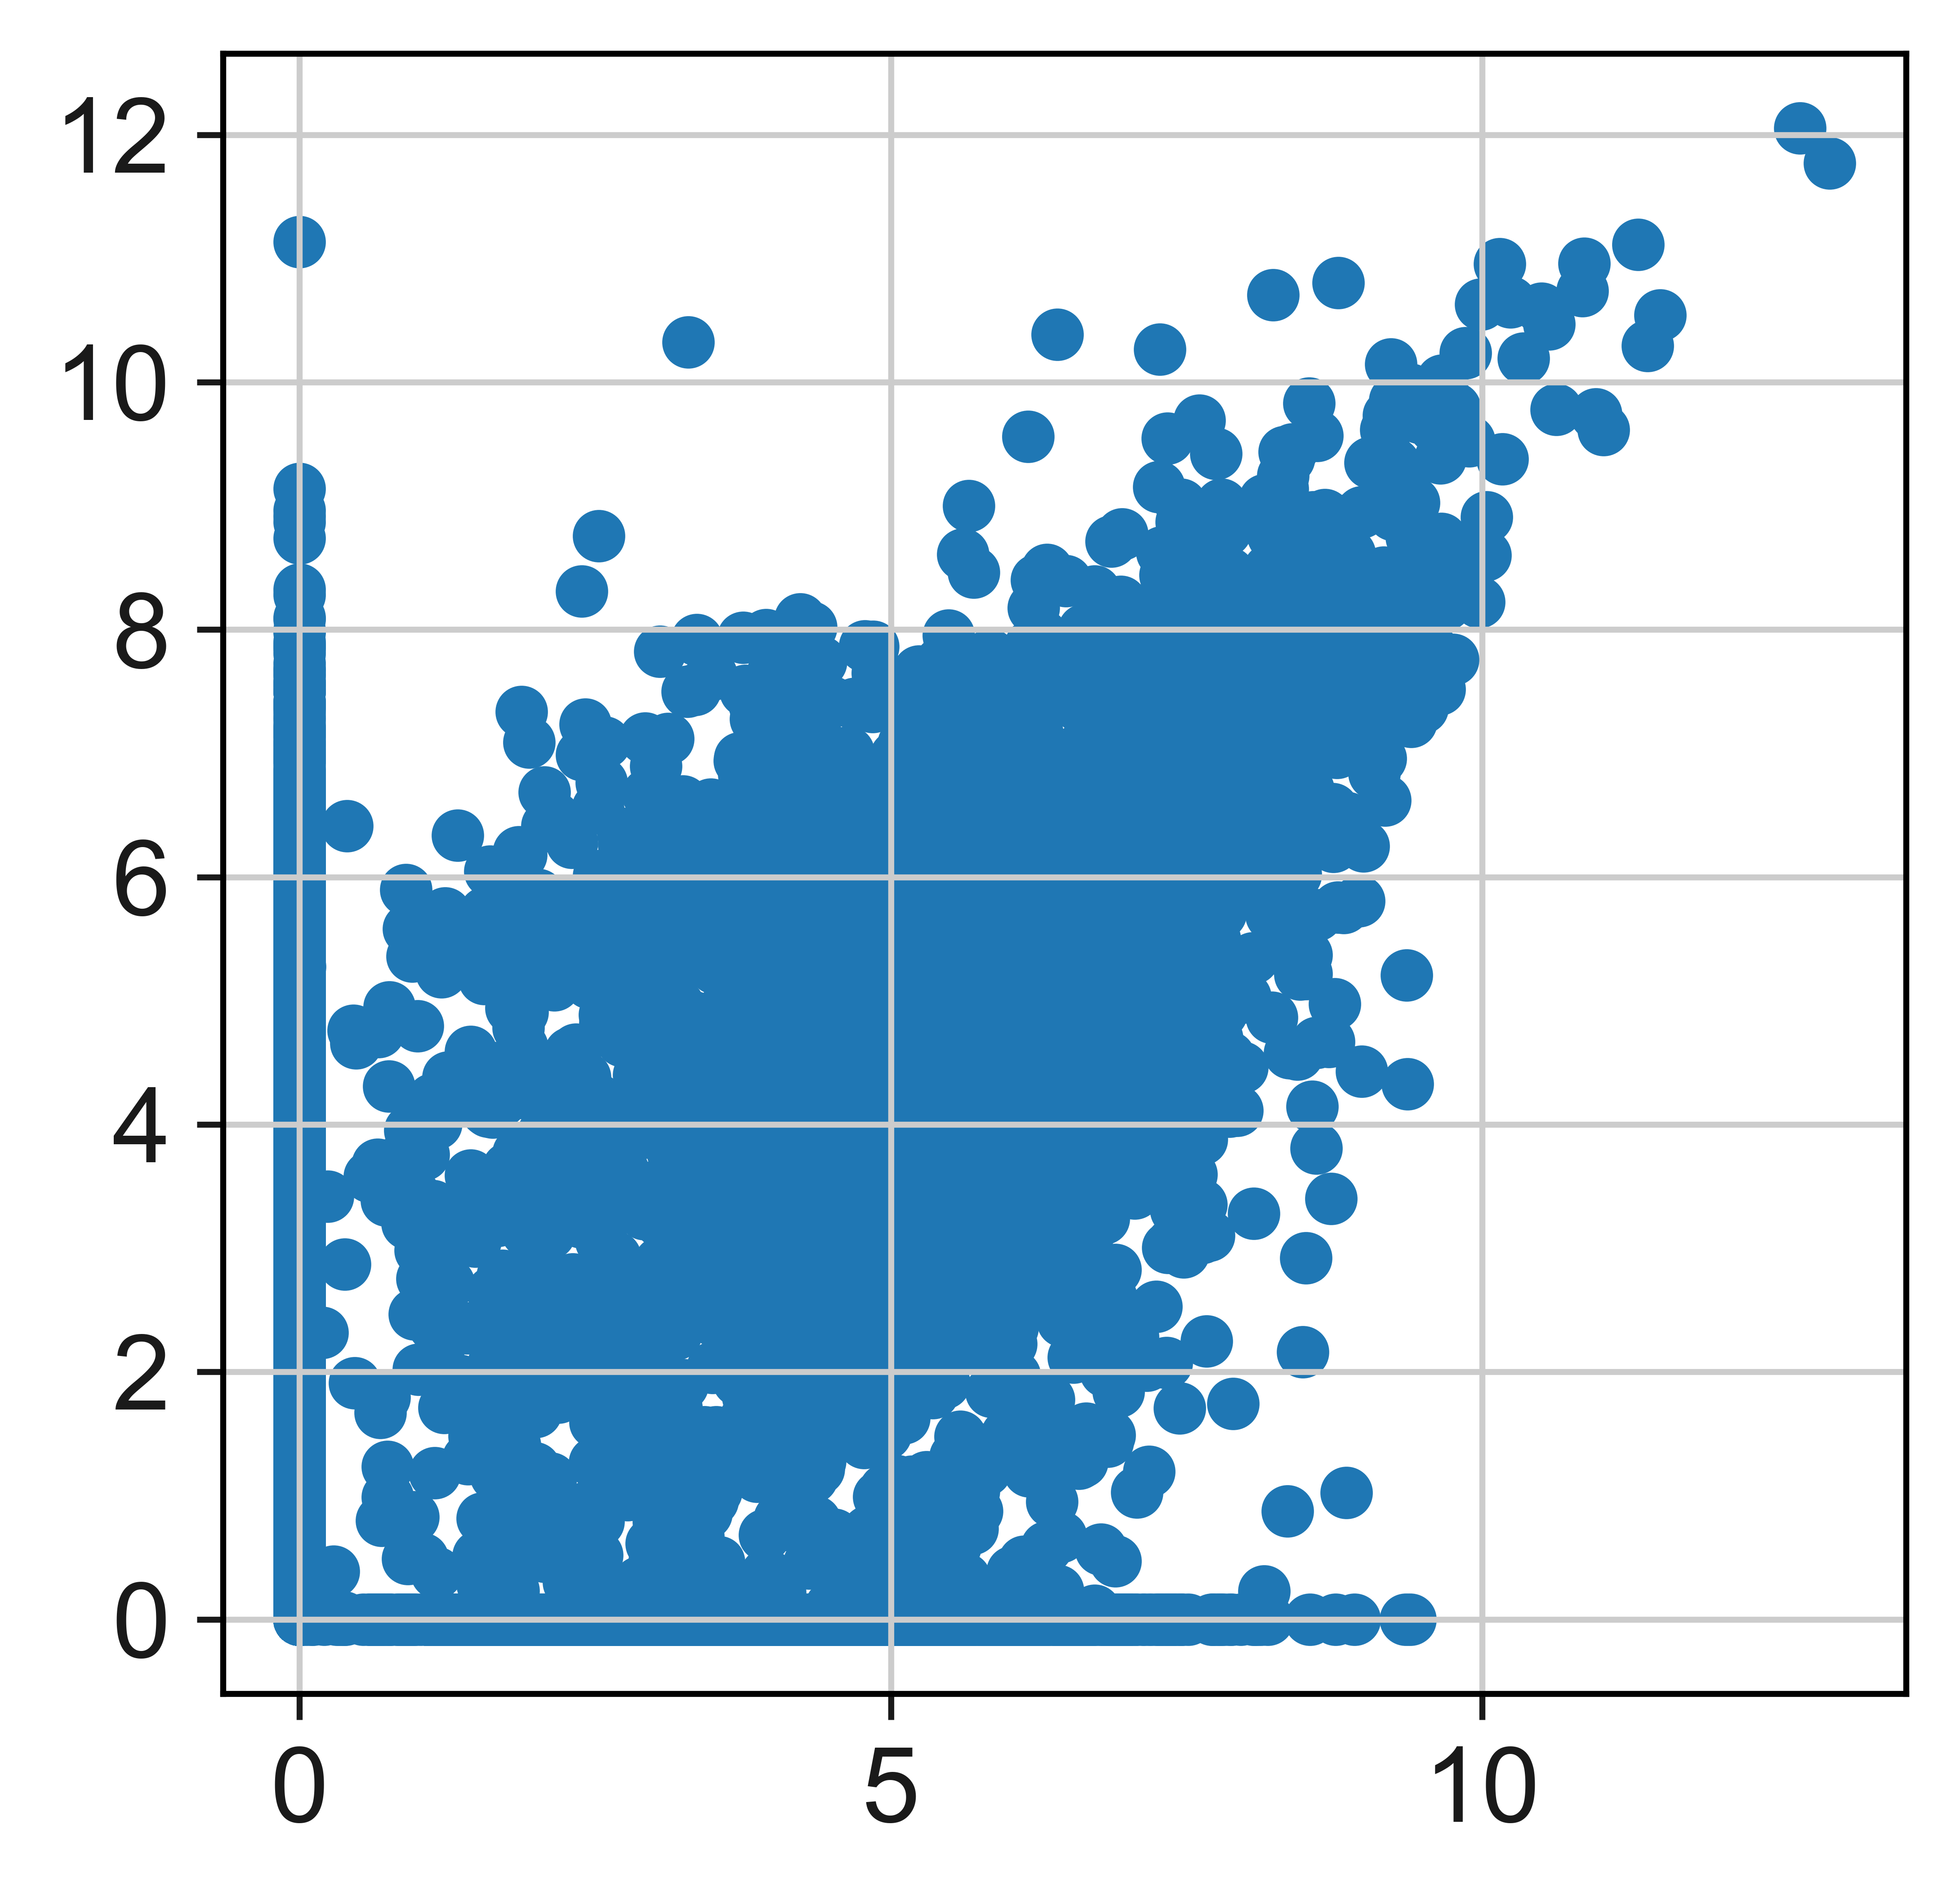

In [4]:
# downloaded data has been normalized
plt.scatter(adata.X[0,:],adata.X[1,:])

In [5]:
# select highly variable genes
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)
adata_var = adata[:, adata.var.highly_variable]

extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


In [6]:
# normalize and compute PCs on highly variable genes
sc.pp.scale(adata_var, max_value=10)
sc.tl.pca(adata_var, svd_solver='arpack')

computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:00)


/home/fenglab/miniconda3/envs/scanpy/lib/python3.8/site-packages/scanpy/preprocessing/_simple.py:843: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)
/home/fenglab/miniconda3/envs/scanpy/lib/python3.8/site-packages/scanpy/preprocessing/_simple.py:843: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  view_to_actual(adata)


In [7]:
# nearest neighbor construction
sc.pp.neighbors(adata_var, n_neighbors=10, n_pcs=16)
sc.tl.umap(adata_var)

computing neighbors
    using 'X_pca' with n_pcs = 16
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:01)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:01)


In [8]:
# compute multiscale diffusion space by Palantir
umap_projections = pd.DataFrame(adata_var.obsm['X_umap'], index=adata_var.obs_names)
dm_res = palantir.utils.run_diffusion_maps(umap_projections)
ms_data = palantir.utils.determine_multiscale_space(dm_res, n_eigs=5)

Determing nearest neighbor graph...
computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)


In [9]:
# construct neighbor graph in multiscale diffusion space
adata_var.obsm['X_palantir'] = ms_data.values
sc.pp.neighbors(adata_var, n_neighbors=100, use_rep='X_palantir')

computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)


In [10]:
# compute force-directed graph by first two umaps
adata_var.obsm['X_umap2d'] = adata_var.obsm['X_umap'][:,:2]
sc.tl.draw_graph(adata_var, init_pos='X_umap2d')

drawing single-cell graph using layout 'fa'
    finished: added
    'X_draw_graph_fa', graph_drawing coordinates (adata.obsm) (0:00:01)


/home/fenglab/miniconda3/envs/scanpy/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


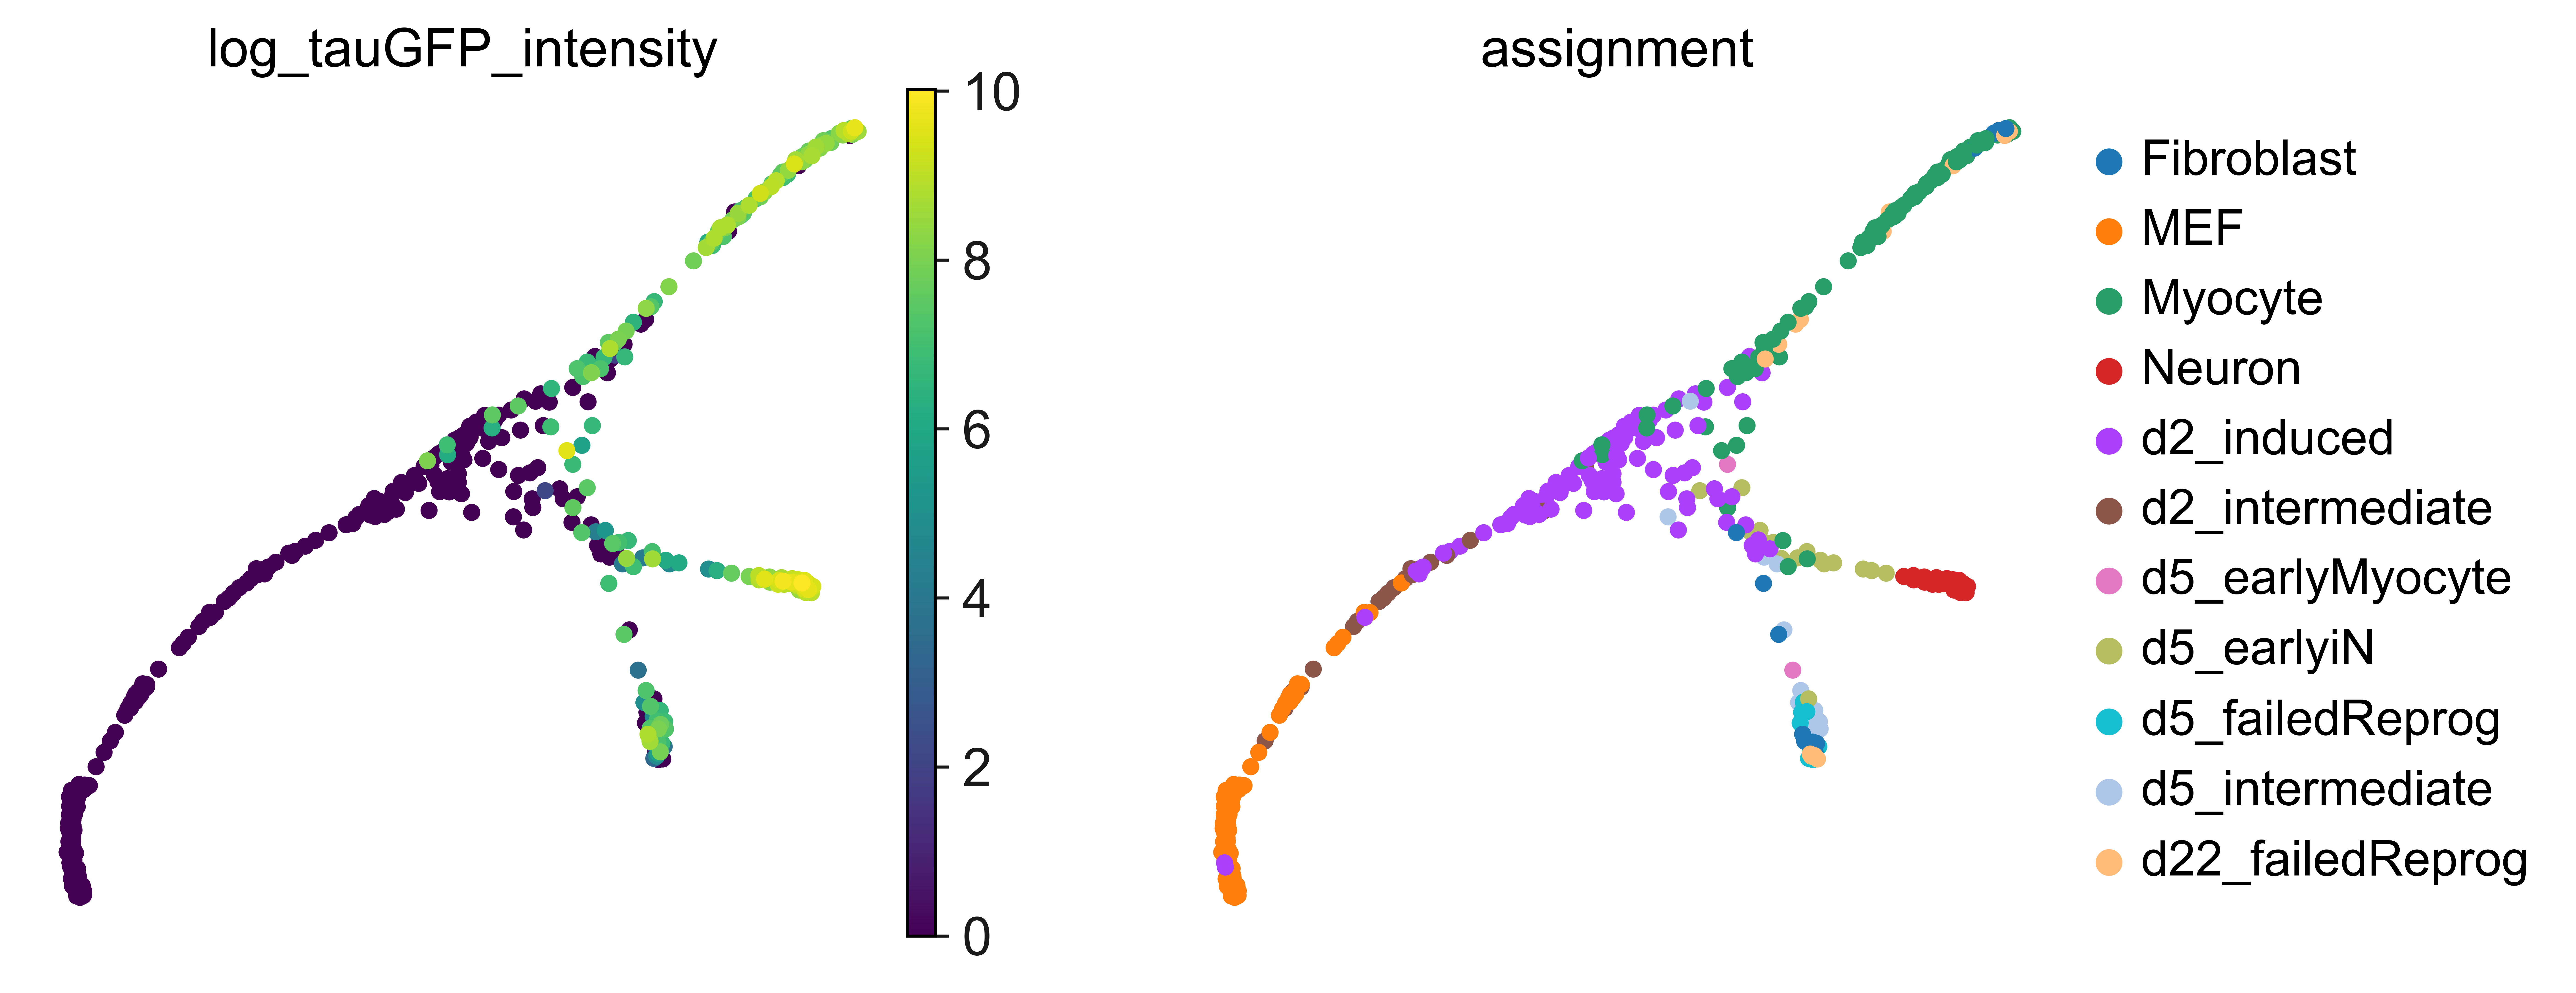

In [11]:
sc.pl.draw_graph(adata_var, color=['log_tauGFP_intensity','assignment'], size=80)

In [12]:
# tree inference
scf.tl.tree(adata_var, method='ppt', nodes=80, use_rep='X_palantir', device='cpu', seed=10, 
            ppt_lambda=400, ppt_sigma=0.4, ppt_nsteps=100)

inferring a principal tree --> parameters used 
    202 principal points, sigma = 0.4, lambda = 400, metric = euclidean
    fitting:  16%|████▋                        | 16/100 [00:01<00:06, 13.15it/s]
    converged
    finished (0:00:01) --> added 
    .uns['ppt'], dictionnary containing inferred tree.
    .obsm['X_R'] soft assignment of cells to principal points.
    .uns['graph']['B'] adjacency matrix of the principal points.
    .uns['graph']['F'] coordinates of principal points in representation space.


/home/fenglab/miniconda3/envs/scanpy/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  cax = scatter(


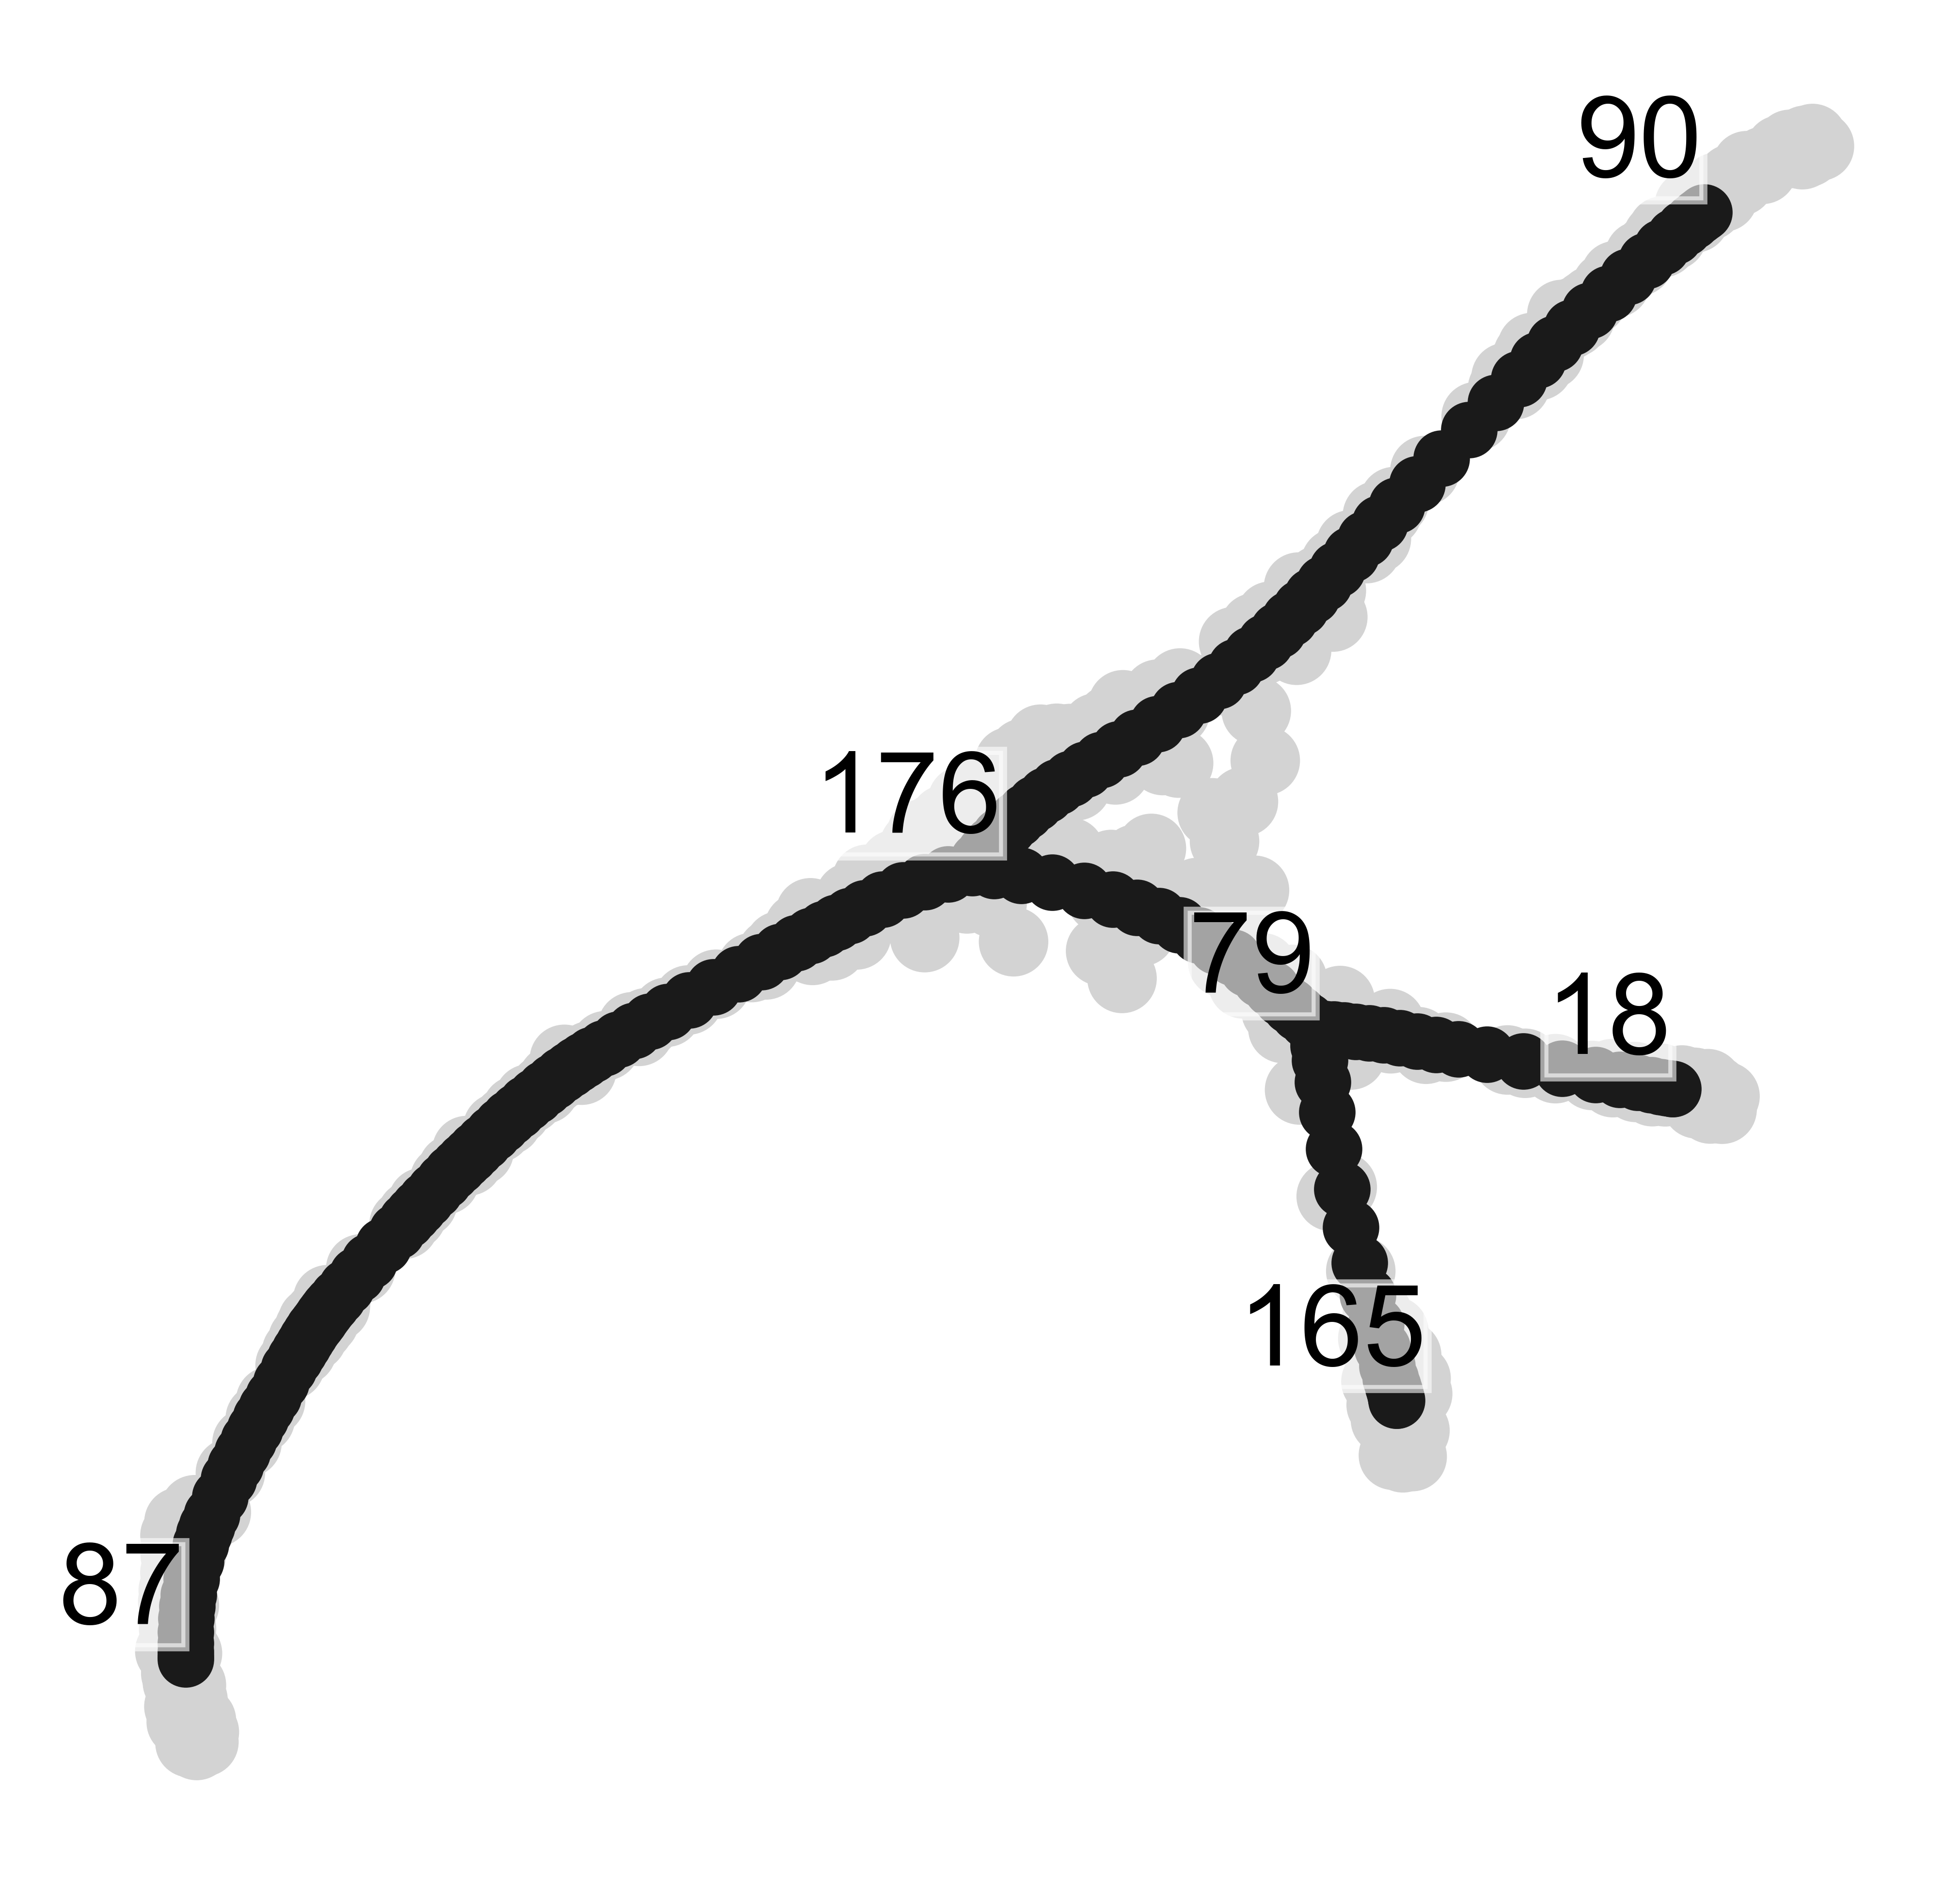

In [13]:
scf.pl.graph(adata_var)

In [14]:
# set MEF as root for pseudotime
scf.tl.root(adata_var,87)

node 87 selected as a root --> added
    .uns['graph']['root'] selected root.
    .uns['graph']['pp_info'] for each PP, its distance vs root and segment assignment.
    .uns['graph']['pp_seg'] segments network information.


projecting cells onto the principal graph
    mappings: 100%|█████████████████████████████| 50/50 [00:20<00:00,  2.39it/s]
    finished (0:00:21) --> added
    .obs['edge'] assigned edge.
    .obs['t'] pseudotime value.
    .obs['seg'] segment of the tree assigned.
    .obs['milestones'] milestone assigned.
    .uns['pseudotime_list'] list of cell projection from all mappings.


/home/fenglab/miniconda3/envs/scanpy/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  cax = scatter(


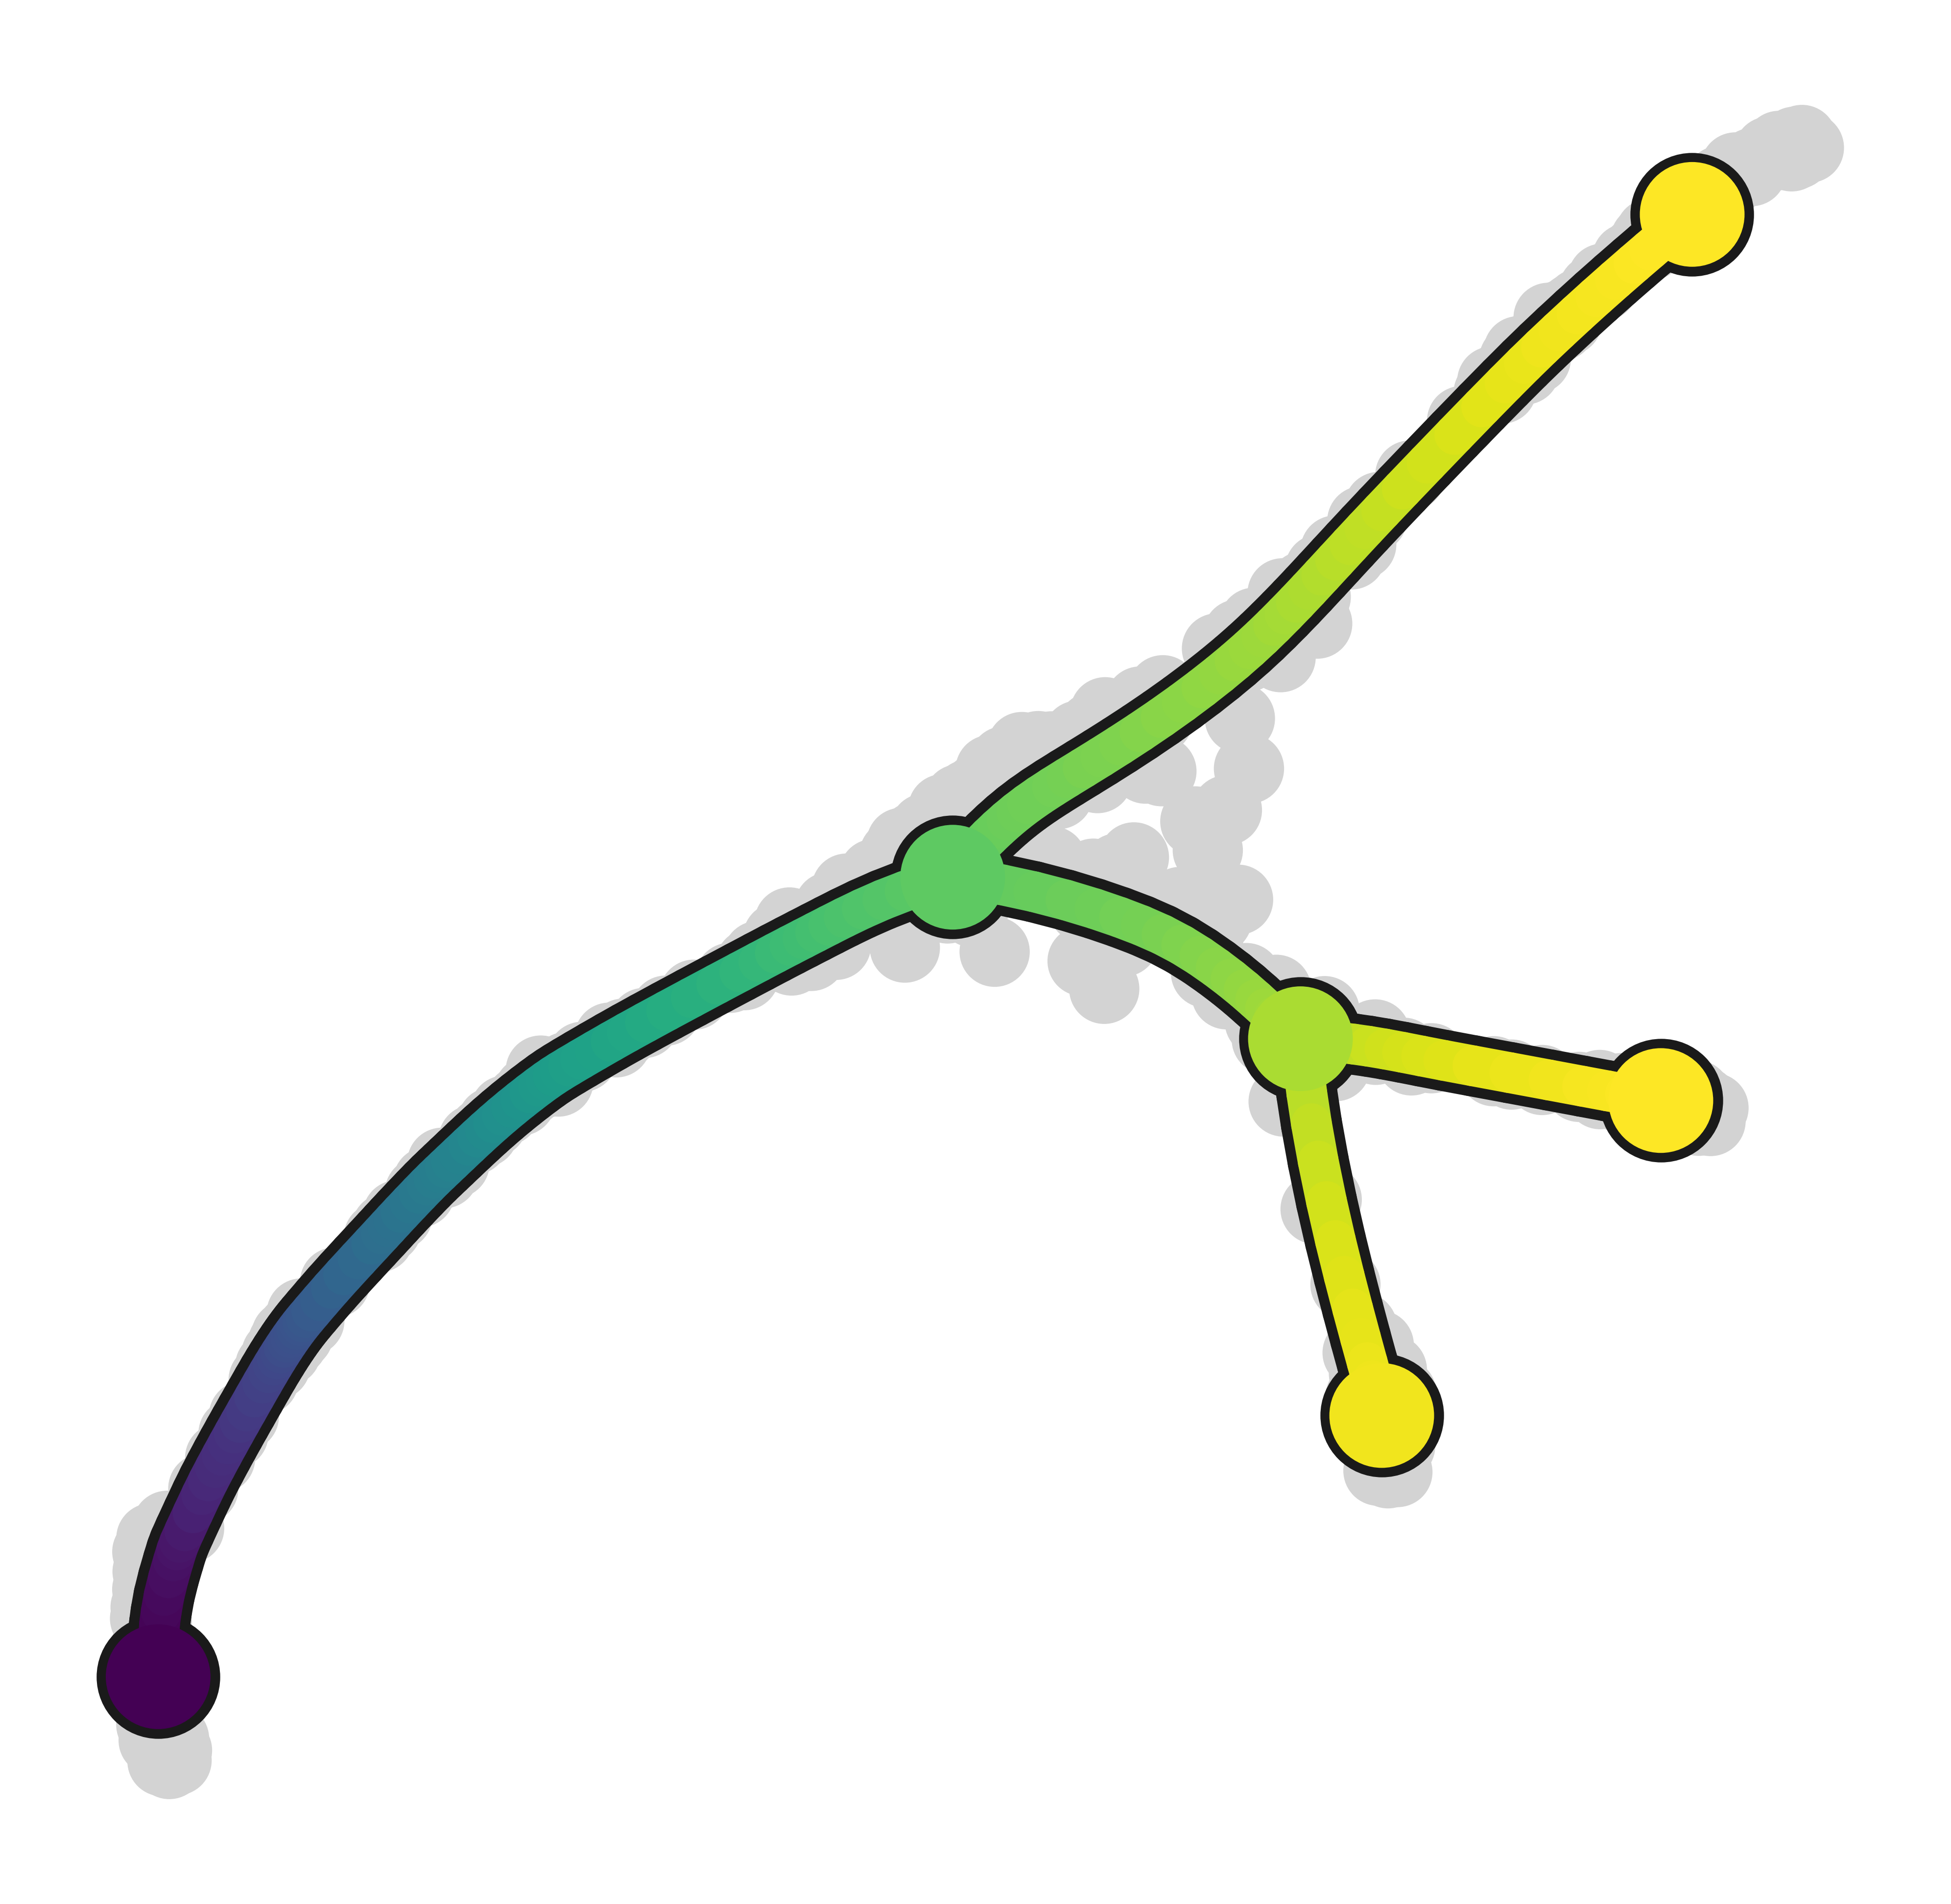

In [15]:
scf.tl.pseudotime(adata_var, n_jobs=8, n_map=50, seed=10)
scf.pl.trajectory(adata_var)

In [16]:
adata_var.uns['assignment_colors'] = ['#555f84','#582813','#79b97c','#be4b0c','#337777','#9b7e71',
                                      '#a9cfb9','#ed9b2b','#b7db8f','#ffbb78','#b6c444']

In [17]:
adata_var.uns['milestones_colors']=['#b6c444','#337777','#be4b0c',
                                   '#ed9b2b','#582813','#79b97c']

/home/fenglab/miniconda3/envs/scanpy/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/fenglab/miniconda3/envs/scanpy/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


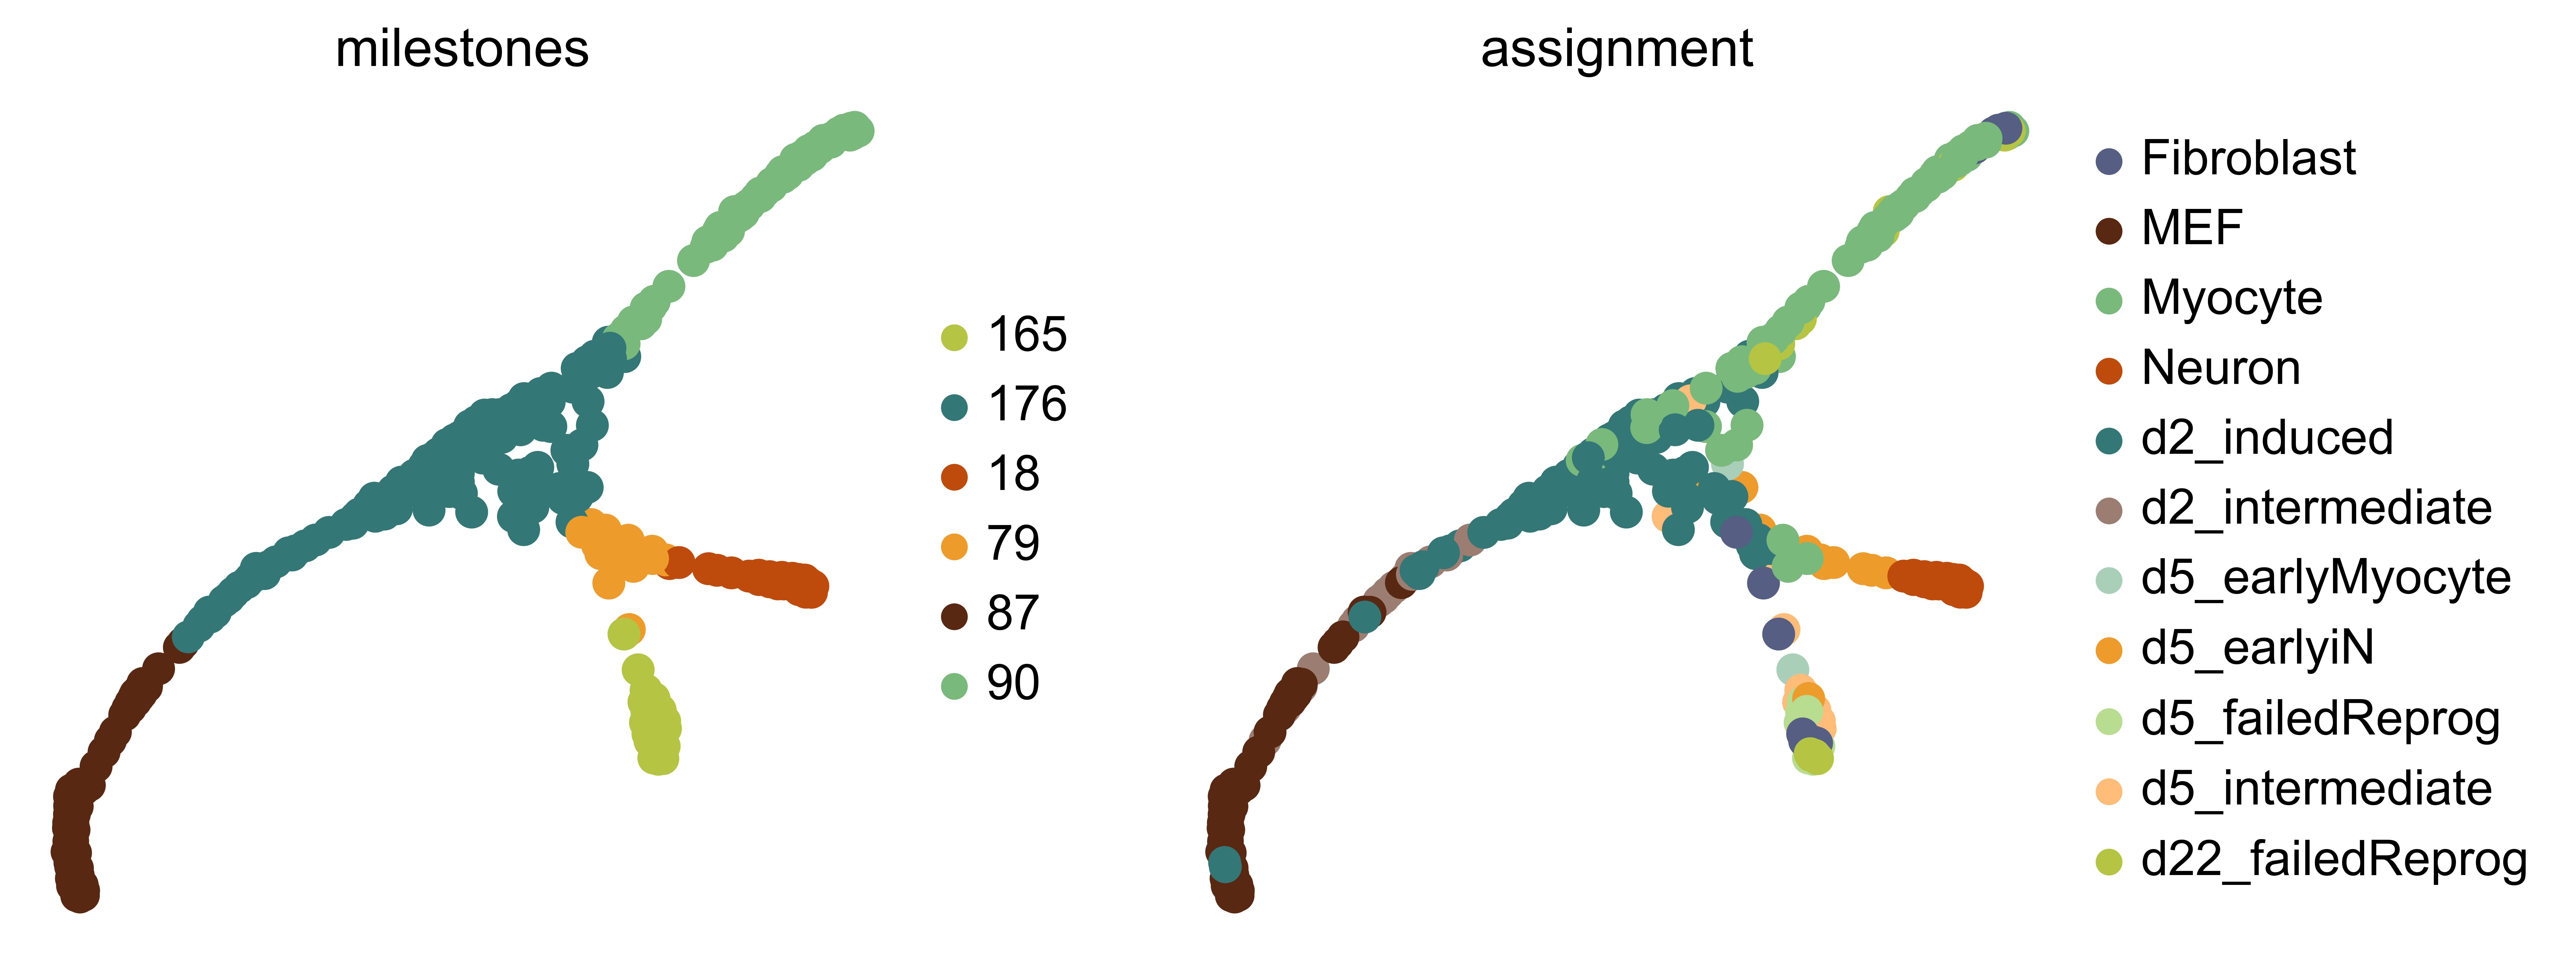

In [18]:
sc.pl.draw_graph(adata_var, color=['milestones','assignment'])

/home/fenglab/miniconda3/envs/scanpy/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


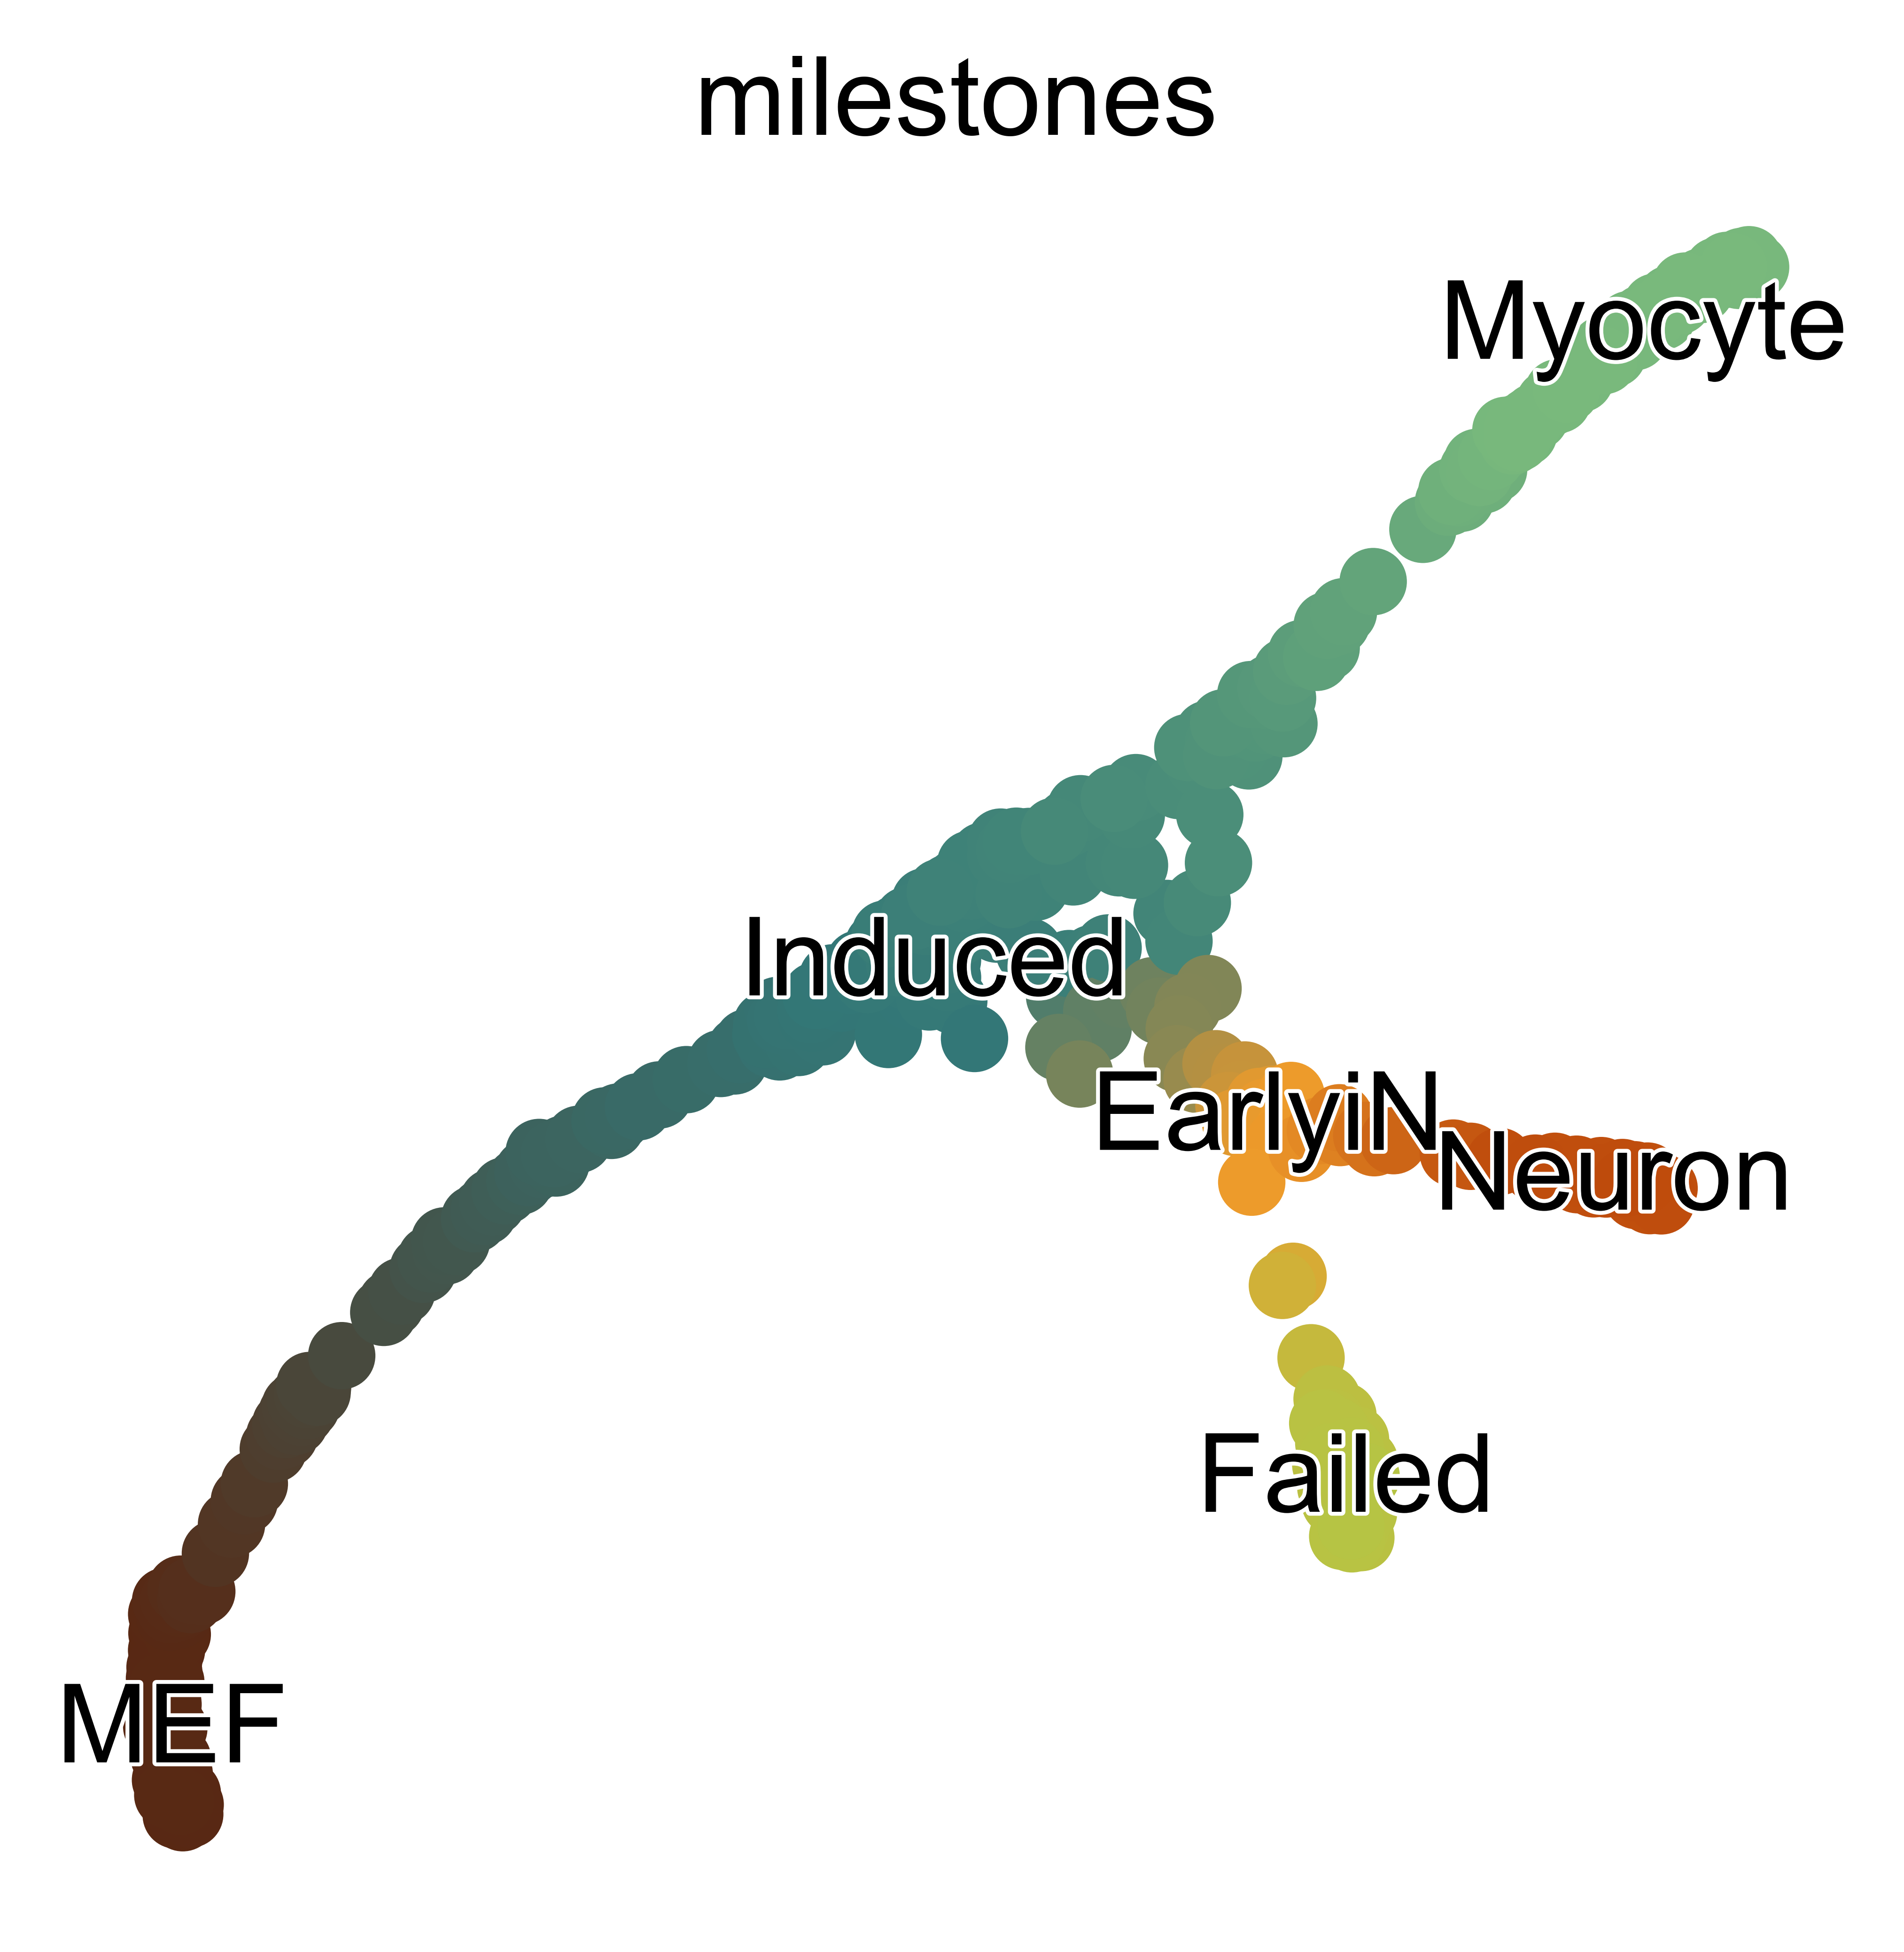

In [19]:
# annotate based on assignment from oroginal data
scf.tl.rename_milestones(adata_var, ['Failed','Induced','Neuron','EarlyiN','MEF','Myocyte'])
scf.pl.milestones(adata_var, annotate=True)

In [20]:
adata_var.raw = adata

In [21]:
sc.pl.draw_graph(adata_var, color=['Syt1','Rbfox3','Nup37','Nup210'], size=150, 
                 cmap='magma', vmin=[0,0,0,0], vmax=[8,3,8,8])

In [22]:
# compute dendrogram for the tree
scf.tl.dendrogram(adata_var)
scf.tl.test_association(adata_var, n_jobs=8)
scf.tl.fit(adata_var, n_jobs=8)

Generating dendrogram of tree
    segment : 100%|███████████████████████████████| 5/5 [00:00<00:00, 36.93it/s]
    finished (0:00:00) --> added 
    .obsm['X_dendro'], new embedding generated.
    .uns['dendro_segments'] tree segments used for plotting.
test features for association with the trajectory
    single mapping : 100%|██████████████████| 3138/3138 [01:05<00:00, 47.68it/s]
    found 254 significant features (0:01:05) --> added
    .var['p_val'] values from statistical test.
    .var['fdr'] corrected values from multiple testing.
    .var['st'] proportion of mapping in which feature is significant.
    .var['A'] amplitue of change of tested feature.
    .var['signi'] feature is significantly changing along pseudotime.
    .uns['stat_assoc_list'] list of fitted features on the graph for all mappings.
fit features associated with the trajectory
    single mapping : 100%|████████████████████| 254/254 [00:03<00:00, 66.67it/s]
    finished (adata subsetted to keep only fitted featur

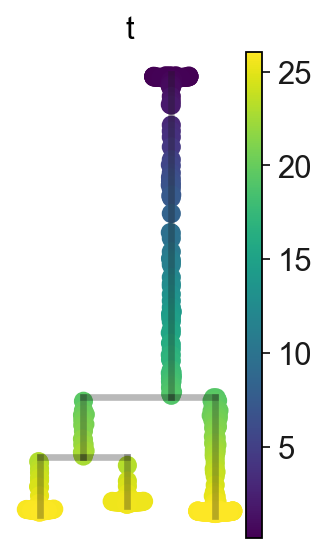

In [23]:
sc.set_figure_params(figsize=(2,4), frameon=False, transparent=True)
scf.pl.dendrogram(adata_var, color='t',cmap='viridis')

/home/fenglab/miniconda3/envs/scanpy/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


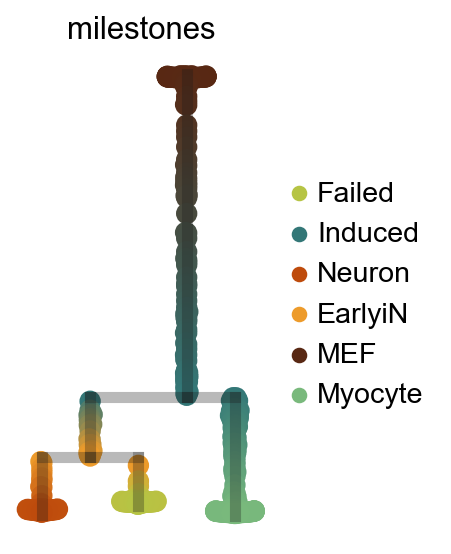

In [24]:
scf.pl.dendrogram(adata_var, color='milestones',color_milestones=True, linewidth_seg=5, size=150)

In [25]:
adata.obsm = adata_var.obsm
adata.uns = adata_var.uns

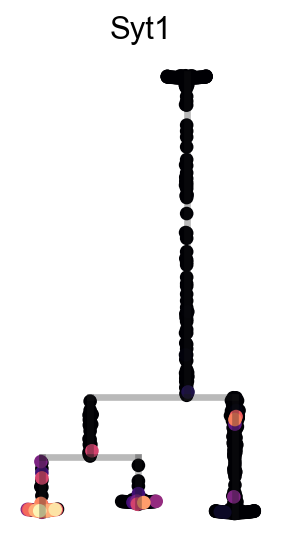

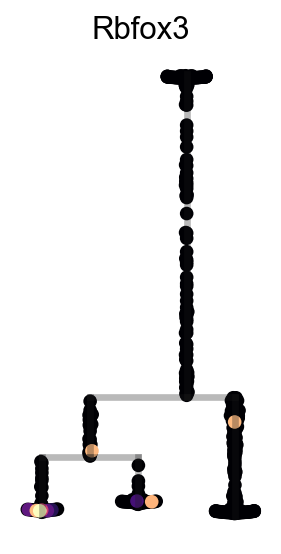

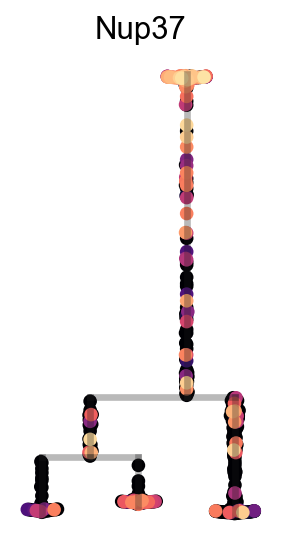

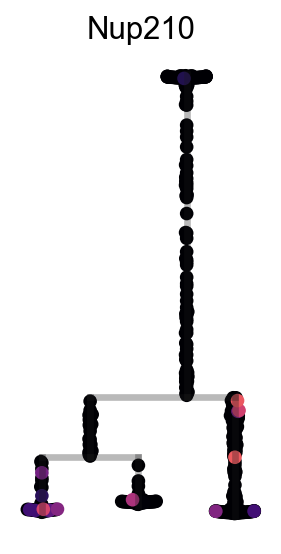

In [26]:
scf.pl.dendrogram(adata, color='Syt1', cmap='magma',linewidth_seg=3,ncols=5, vmin=0, vmax=8, size=150, colorbar_loc=None)
scf.pl.dendrogram(adata, color='Rbfox3', cmap='magma',linewidth_seg=3,ncols=5, vmin=0, vmax=3, size=150, colorbar_loc=None)
scf.pl.dendrogram(adata, color='Nup37', cmap='magma',linewidth_seg=3,ncols=5, vmin=0, vmax=8, size=150, colorbar_loc=None)
scf.pl.dendrogram(adata, color='Nup210', cmap='magma',linewidth_seg=3,ncols=5, vmin=0, vmax=8, size=150, colorbar_loc=None)